In [1]:
'''
REF: Exploratory Analysis
'''

'\nREF: Exploratory Analysis\n'

# Introduction 

In this notebook, we will conduct an initial exploratory analysis of Indonesia climate data collected between 2010 and 2020.

Our goal here is to gather a high-level look via summary statistics and visualizations so that we can gain an idea of how we might proceed with more segmented and specific analysis, perhaps for a specific province, region or weather station.

In [2]:
'''
Introduction - Setup 
'''

from pandas import DataFrame, Series
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime

df_climate_data_staging = pd.read_csv('Data/climate_data.csv')
df_climate_data_staging.head()

column_renaming_dict = {
    'Tn':'temp_min',
    'Tx':'temp_max',
    'Tavg':'temp_avg',
    'RH_avg':'humidity_avg',
    'RR':'rainfall',
    'ss':'duration_sunshine_hr',
    'ff_x':'wind_speed_max',
    'ddd_x':'wind_direction_at_max_speed',
    'ff_avg':'wind_speed_avg',
    'ddd_car':'wind_direction_most_frequent',
    'station_id':'station_id',
    'date':'date_recorded'
}

df_climate_data = df_climate_data_staging.rename(columns=column_renaming_dict)
df_provinces = pd.read_csv('Data/province_detail.csv')
df_stations = pd.read_csv('Data/station_detail.csv')

'''
Setup - Transformations
'''

# transforming datetime format to US
df_climate_data = df_climate_data.assign(date_recorded=df_climate_data['date_recorded'].apply(lambda x: datetime.strptime(x,'%d-%m-%Y')))

# converting index to DatetimeIndex type
df_climate_data.set_index(pd.DatetimeIndex(df_climate_data.index)) 

# producing denormlized set by merging all dataframes
df_climate_data = df_climate_data\
    .merge(df_stations,how='inner',left_on='station_id',right_on='station_id')\
		.merge(df_provinces,how='inner',left_on='province_id',right_on='province_id')

In [3]:
'''
Filtering out the extreme temperatures from the plot:

The signifiant maximums are still a little suspicious and it may be worthwhile to investigate their validity a little more.

What's worth calling out here is there is not an obvious upward increase in temperature that might expect to see as a result of global warming, however global warming overall is slight (i.e. 1 degree C over an entire century) in the context of the temperature range, and shouldn't be apparent here anyways.
....
'''
df_climate_data= df_climate_data[(df_climate_data.temp_min > 0) & (df_climate_data.temp_max < 50)]
df_climate_data  = df_climate_data[(df_climate_data.humidity_avg <= 100)]
df_climate_data = df_climate_data[(df_climate_data.temp_max > df_climate_data.temp_min)]

df_climate_data = df_climate_data[df_climate_data.rainfall < 500]

# Time Series Visualization

Visualizing time-oriented metric values for these metrics in the dataset:
 - Daily Maximum Temperature
 - Daily Minimum Temperature
 - Daily Average Temperature
 - Daily Rainfall
 - Maximum Daily Humidity
 - Minimum Daily Humidity

How weather (and climate) vary over time seems especially relevant to analyze and so we'll start with such.

[]

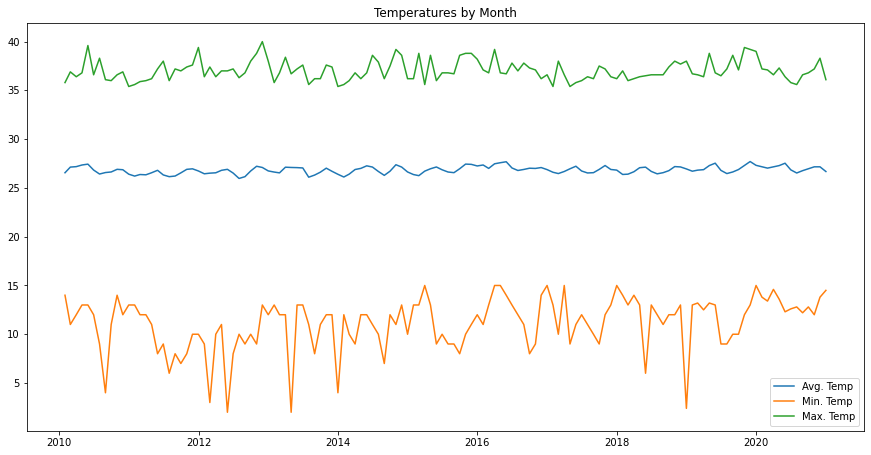

In [4]:
'''
Plotting time-series charts after having filtered the outliers

Plotting the sampled minimum, maximum, and average temperatures all in one plot.
'''

# creating aggregate functions to be applied to the grouped data
temp_min_named_agg = pd.NamedAgg('temp_min','min')
temp_max_named_agg = pd.NamedAgg('temp_max','max')
temp_avg_named_agg = pd.NamedAgg('temp_avg','mean')
temp_avg_named_count = pd.NamedAgg('temp_avg','count')

# grouping and aggregating data
# initially group by the date recorded - further aggregate for higher-level rollup in subsequent statements
df_climate_data_tmp = df_climate_data.groupby('date_recorded')\
    .agg(
        temp_max=temp_max_named_agg, 
				temp_min=temp_min_named_agg, 
				temp_avg=temp_avg_named_agg,
        temp_count=temp_avg_named_count
			)

# resampling the aggregated data to provide month-level view of weather statistics
'''
Time Series Charts -- Time Resampling

Further group and aggregate over each month of recordings. 

The average temperature calculation performs as follows:

(avg1*count1 + avg2*count2 + ... + avgN*countN)/(count1 + count2 + ... + countN)

Some additional commentary:

It seems that the resample(),agg(), and apply() functions all accept 
lamdba functions where the 'data' argument that is passed to each is 
dependent on the object passed - i.e. if we're calling dataframe.apply(lambda x: x)
then 'x' is a DataFrame object (i.e. what the apply() is acting on in this context)
, whereas if we call series.apply(lambda x: x) then x is that Series object the apply() 
function is acting on.
'''
df_climate_data_tmp2 = DataFrame(
    {
        'temp_max':df_climate_data_tmp['temp_max'].resample('1M').max(),
     		'temp_min':df_climate_data_tmp['temp_min'].resample('1M').min(),
				'temp_avg':df_climate_data_tmp.resample('1M').agg(func=lambda x: sum(x.temp_count * x.temp_avg)/sum(x.temp_count))
		}
  )

# plotting time-series charts against same 'axes' object
fig, ax = plt.subplots(figsize=(15,7.5))
ax.set_title('Temperatures by Month')
ax.plot(df_climate_data_tmp2.index,df_climate_data_tmp2['temp_avg'], label='Avg. Temp')
ax.plot(df_climate_data_tmp2.index,df_climate_data_tmp2['temp_min'], label='Min. Temp')
ax.plot(df_climate_data_tmp2.index,df_climate_data_tmp2['temp_max'], label='Max. Temp')
ax.legend()
ax.plot()

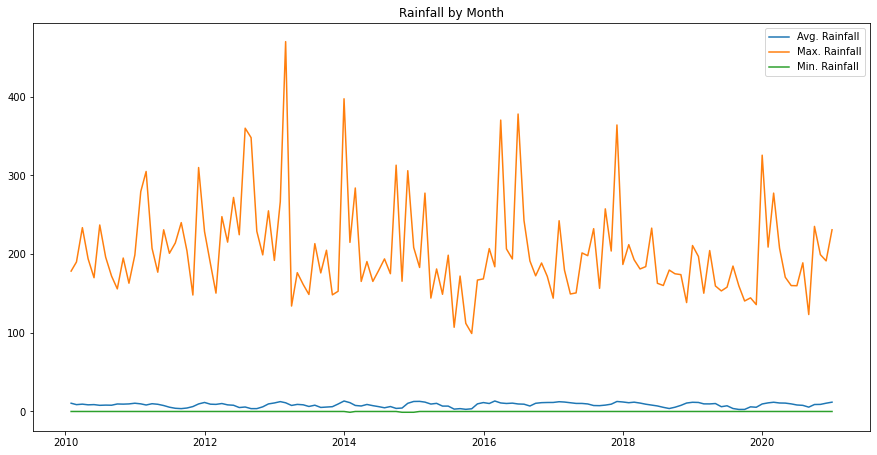

In [5]:
'''
Time Series Charts - Rainfall
'''

rainfall_min_named_agg = pd.NamedAgg('rainfall','min')
rainfall_max_named_agg = pd.NamedAgg('rainfall','max')
rainfall_avg_named_agg = pd.NamedAgg('rainfall','mean')
rainfall_avg_named_count = pd.NamedAgg('rainfall','count')

df_climate_data_tmp = df_climate_data.groupby('date_recorded')\
    .agg(
        rainfall_max=rainfall_max_named_agg, 
				rainfall_min=rainfall_min_named_agg, 
				rainfall_avg=rainfall_avg_named_agg,
        rainfall_count=rainfall_avg_named_count
			)

df_climate_data_tmp2 = DataFrame(
    {
        'rainfall_max':df_climate_data_tmp['rainfall_max'].resample('1M').max(),
     		'rainfall_min':df_climate_data_tmp['rainfall_min'].resample('1M').min(),
				'rainfall_avg':df_climate_data_tmp.resample('1M').agg(func=lambda x: sum(x.rainfall_count * x.rainfall_avg)/sum(x.rainfall_count))
		}
  )

fig, ax = plt.subplots(figsize=(15,7.5))
ax.set_title('Rainfall by Month')
# df_climate_data_tmp2.rainfall_max
ax.plot(df_climate_data_tmp2.index,df_climate_data_tmp2['rainfall_avg'], label='Avg. Rainfall')
ax.plot(df_climate_data_tmp2.index,df_climate_data_tmp2['rainfall_max'], label='Max. Rainfall')
ax.plot(df_climate_data_tmp2.index,df_climate_data_tmp2['rainfall_min'], label='Min. Rainfall')
ax.legend()

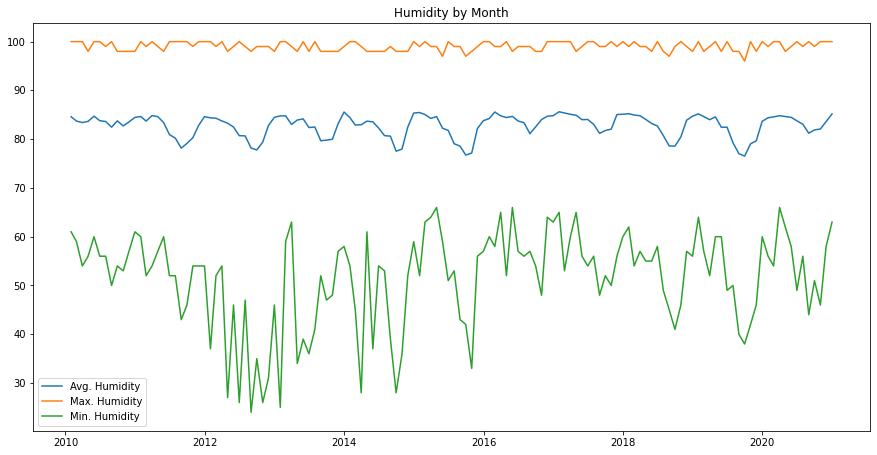

In [6]:
'''
Time Series Charts - Humidity
'''

humidity_min_named_agg = pd.NamedAgg('humidity_avg','min')
humidity_max_named_agg = pd.NamedAgg('humidity_avg','max')
humidity_avg_named_agg = pd.NamedAgg('humidity_avg','mean')
humidity_avg_named_count = pd.NamedAgg('humidity_avg','count')

df_climate_data_tmp = df_climate_data.groupby('date_recorded')\
    .agg(
        humidity_max=humidity_max_named_agg, 
				humidity_min=humidity_min_named_agg, 
				humidity_avg=humidity_avg_named_agg,
        humidity_count=humidity_avg_named_count
			)

df_climate_data_tmp2 = DataFrame(
    {
        'humidity_max':df_climate_data_tmp['humidity_max'].resample('1M').max(),
     		'humidity_min':df_climate_data_tmp['humidity_min'].resample('1M').min(),
				'humidity_avg':df_climate_data_tmp.resample('1M').agg(func=lambda x: sum(x.humidity_count * x.humidity_avg)/sum(x.humidity_count))
		}
  )

fig, ax = plt.subplots(figsize=(15,7.5))
ax.set_title('Humidity by Month')
# df_climate_data_tmp2.rainfall_max
ax.plot(df_climate_data_tmp2.index,df_climate_data_tmp2['humidity_avg'], label='Avg. Humidity')
ax.plot(df_climate_data_tmp2.index,df_climate_data_tmp2['humidity_max'], label='Max. Humidity')
ax.plot(df_climate_data_tmp2.index,df_climate_data_tmp2['humidity_min'], label='Min. Humidity')
ax.legend()

In [7]:
'''
Time Series Charts - Duration of Sunshine
'''

sunshine_min_named_agg = pd.NamedAgg('duration_sunshine_hr','min')
sunshine_max_named_agg = pd.NamedAgg('duration_sunshine_hr','max')
sunshine_avg_named_agg = pd.NamedAgg('duration_sunshine_hr','mean')
sunshine_avg_named_count = pd.NamedAgg('duration_sunshine_hr','count')

df_climate_data_tmp = df_climate_data.groupby('date_recorded')\
    .agg(
        sunshine_max=sunshine_max_named_agg, 
				sunshine_min=sunshine_min_named_agg, 
				sunshine_avg=sunshine_avg_named_agg,
        sunshine_count=sunshine_avg_named_count
			)

df_climate_data_tmp2 = DataFrame(
    {
        'sunshine_max':df_climate_data_tmp['sunshine_max'].resample('1M').max(),
     		'sunshine_min':df_climate_data_tmp['sunshine_min'].resample('1M').min(),
				'sunshine_avg':df_climate_data_tmp.resample('1M').agg(func=lambda x: sum(x.sunshine_count * x.sunshine_avg)/sum(x.sunshine_count))
		}
  )

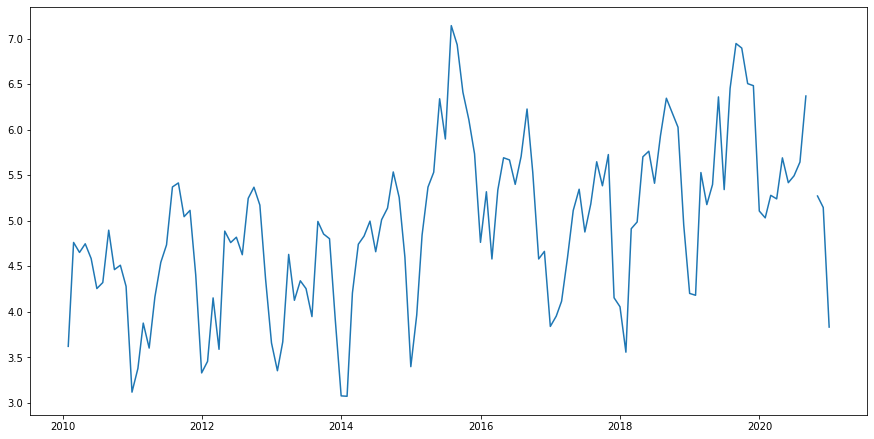

In [121]:
# plotting average sunshine duration resulting from previous transformations
fig, ax = plt.subplots(figsize=(15,7.5))
ax.plot(df_climate_data_tmp2.index,df_climate_data_tmp2['sunshine_avg'])

# Summary Statistics

In this section we aim to take a top-down analysis approach, by first looking at some numerical descriptive statistics and then utlizing appropriate visualizations to provide more 'color' to these results.

We'll focus specifically on aggregated statistics of daily maximum temperature by province and seek to understand how we can generalize this approach to other statistical measures for subsequent analysis.

Let's start off with look at the standard descriptive summary statistics using the `describe()` method.

In [90]:
# execute describe() as alternative to previous code execution 
'''
TODO: T_2023_07_09_0

Analyzing the output below in Excel to 
  - [ ] If there isn't a visulization opportunity obvious, identify some questions to ask of the data
  	- Limit analysis to 1 or 2 metrics to enable more focused effort 
    - Analyze for temp_avg, temp_min
	- [ ] Identify 2 - 3 visualization opportunties
  - [ ] Identify and describe general approaches for using summary statistics as a 'map' for deeper analysis in notebook's conclusion (or elsewhere)

The motivation here is to understand how we can use summary statistics to scope-out opportunities for visualization.
'''
df_province_desc = df_climate_data[
    ['province_id',
     'province_name',
			# 'humidity_avg',
			# 'rainfall',	
			'temp_max',
			# 'temp_min',
			# 'temp_avg'
			]].groupby(['province_id','province_name'])\
    .describe()

In [102]:
def get_summary_dataframe(df_described,column_name,statistic):
	'''
	This function returns a column sub-selection of a grouped and described
	dataframe.

	This function was originally created to allow us to more easily
	adjust the province_name (originally an index) to a column if needed.
	'''
	df_tmp = df_described[column_name]
	return df_tmp[[statistic]]

``` 
TODO: T_2023_07_12_1 - Summary Analysis Writing

Observations and questions to ask of data. These are 'internal' thoughts intended to become 'public' writing.

- [ ] Identify intent of each section and comment with such
- [ ] Re-organize writing according to intent of section and make for public focus
```

For an initial look at the summary statistics, let's focus on the temp_max column in the dataset. It should be reiterated that the **temp_max** column is the maximum recorded temperature for a given day and station, while temp_min and temp_avg are respectively the minimum and average daily recorded temperatures. It *may* be confusing that we're analyzing *minimum* temp_max and a *maximum* temp_min (for instance), but these averages and minimums described are in the context of what the minimum, average, or maximum daily extreme is for each month.


In [108]:
get_summary_dataframe(df_province_desc,'temp_max','std').sort_values(by='std',ascending=False).head(10)

,,std
province_id,province_name,
12,Jawa Barat,3.268062
32,Papua,2.657224
19,Nusa Tenggara Timur,2.653962
15,Jawa Timur,2.594712
26,Sulawesi Selatan,2.172377
5,Jambi,2.087504
3,Sumatera Barat,2.055062
24,Sulawesi Utara,2.025649
1,Nanggroe Aceh Darussalam,1.998711


Here we see that Jawa Barat is the province with the highest temp_max standard deviation of 3.2 C 

In [110]:
get_summary_dataframe(df_province_desc,'temp_max','min').sort_values(by='min',ascending=True).head(10)

,,min
province_id,province_name,
19,Nusa Tenggara Timur,15.9
32,Papua,16.3
15,Jawa Timur,16.4
5,Jambi,19.1
12,Jawa Barat,19.3
1,Nanggroe Aceh Darussalam,20.2
24,Sulawesi Utara,20.6
3,Sumatera Barat,20.8
26,Sulawesi Selatan,20.8


Here we see that Nusa Tenggara Timur has the lowest daily maximum temp_max on record out of all the provinces, with a recording of 15.9 C. 

In [112]:
get_summary_dataframe(df_province_desc,'temp_max','max').sort_values(by='max',ascending=False).head(10)

,,max
province_id,province_name,
30,Maluku,40.0
2,Sumatera Utara,39.6
5,Jambi,39.4
13,Jawa Tengah,39.4
33,Papua Barat,39.2
8,Lampung,39.2
12,Jawa Barat,39.2
18,Nusa Tenggara Barat,39.0
26,Sulawesi Selatan,39.0


To provide a little bit of context to these extreme data points, let's create a time series graph to see how a couple of the extremes appear adjacent to other dates for their respective stations:
 - Minimum temp_max of 15.9 C, recorded at a Maluku station in 2010
 - Maximum temp_max of 40 C, recorded at a West Java station in 2012

[]

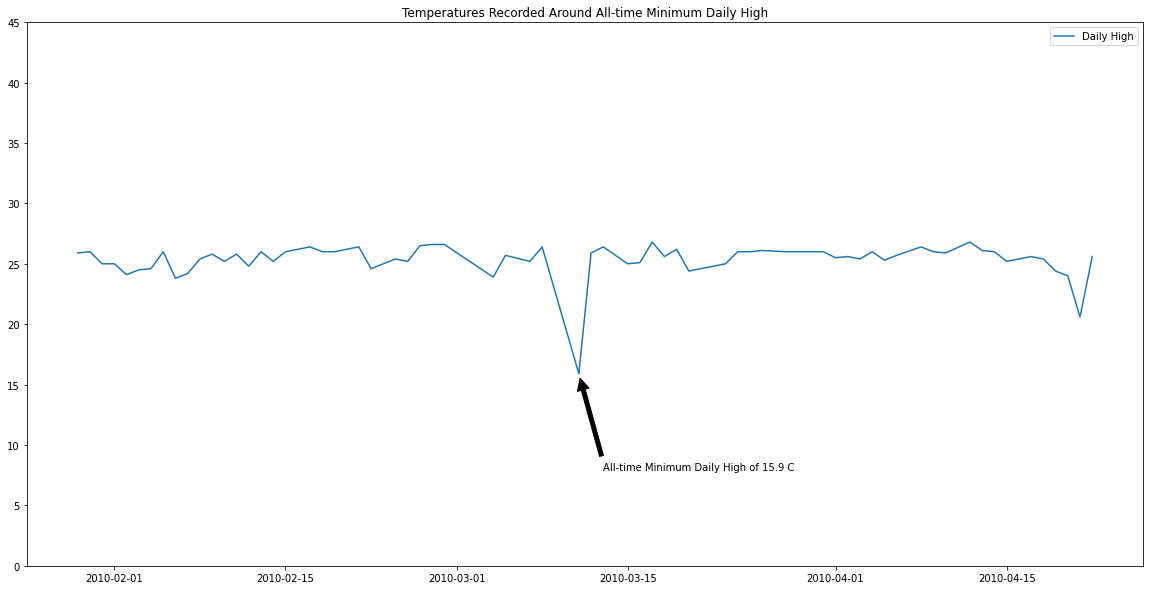

In [127]:
# Time Series for 15.1 minimum temperature
df_chart = df_climate_data[
    (df_climate_data.station_id == 97284) 
		& (df_climate_data.date_recorded <= datetime.fromisoformat('2010-03-11') + pd.DateOffset(weeks=6)) # less than n weeks ahead of date focus
		& (df_climate_data.date_recorded > datetime.fromisoformat('2010-03-11') - pd.DateOffset(weeks=6)) # more than n weeks before date focus
		]


# store the lowest temp max coordinates for annotation
df_min = df_chart[['temp_max','date_recorded']][df_chart['temp_max'] == 15.9]

df_chart.set_index('date_recorded',inplace=True)
fig, ax = plt.subplots(figsize=(20,10))
ax.set_title('Temperatures Recorded Around All-time Minimum Daily High')
ax.plot(df_chart.index,df_chart['temp_max'], label='Daily High')
plt.ylim([0,45])

# setting annotation
x = df_min.date_recorded.max() # using max() to convert 1-record series to scalar
y = df_min.temp_max.max() # using max() to convert 1-record series to scalar
x_text = x + pd.DateOffset(days=2)
y_text = y - 8
ax.annotate(f'All-time Minimum Daily High of {y} C', xy = (x,y),xytext=(x_text,y_text),arrowprops=dict(facecolor='black', shrink=0.05))

ax.legend()
ax.plot()

[]

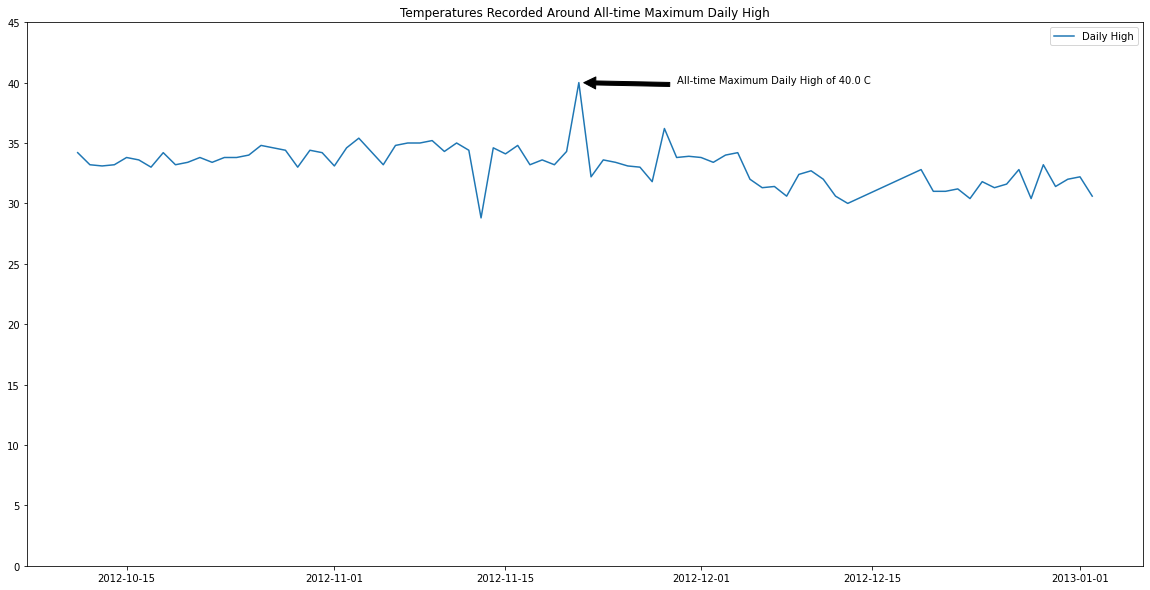

In [128]:
df_climate_data[df_climate_data.temp_max == 40]

# Time Series 
df_chart = df_climate_data[
    (df_climate_data.station_id == 97810) 
		& (df_climate_data.date_recorded <= datetime.fromisoformat('2012-11-21') + pd.DateOffset(weeks=6)) # less than 2 weeks ahead of date focus
		& (df_climate_data.date_recorded > datetime.fromisoformat('2012-11-21') - pd.DateOffset(weeks=6)) # more than 2 weeks before date focus
		]

# store the lowest temp max coordinates for annotation
df_max= df_chart[['temp_max','date_recorded']][df_chart['temp_max'] == 40.0]

df_chart.set_index('date_recorded',inplace=True)
fig, ax = plt.subplots(figsize=(20,10))
ax.set_title('Temperatures Recorded Around All-time Maximum Daily High')
plt.ylim([0,45])
ax.plot(df_chart.index,df_chart['temp_max'], label='Daily High')

# setting annotation
x = df_max.date_recorded.max()
y = df_max.temp_max.max()
x_text = x + pd.DateOffset(days=8)
y_text = y

ax.annotate(f'All-time Maximum Daily High of {y} C', xy = (x,y),xytext=(x_text,y_text),arrowprops=dict(facecolor='black', shrink=0.05))

ax.legend()
ax.plot()

<class 'matplotlib.axes._subplots.AxesSubplot'>


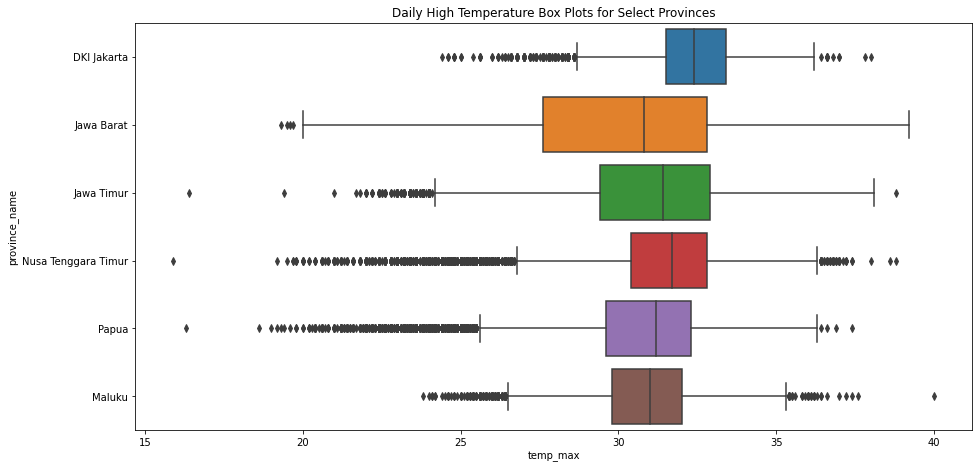

In [129]:
'''
TODO: T_2023_07_15_1

Further research - what does do the whiskers in the box and whisker plot mean, and can I prove that the +- 1.5*IQR standard is somewhat divorced from matching up with a particular percentile? (i.e. 90% or 10%)
'''

df_tmp = df_climate_data\
	[
	# select columns
		['province_name','temp_max']
  ]\
	[
	# filter records
	df_climate_data.province_name.isin(['DKI Jakarta','Jawa Barat','Nusa Tenggara Timur','Papua','Maluku','Jawa Timur'])
	]

fig, ax = plt.subplots(figsize=(15,7.5))
ax.set_title('Daily High Temperature Box Plots for Select Provinces')
result = sns.boxplot(y=df_tmp.province_name, x=df_tmp.temp_max)
print(type(result))

In [15]:
'''
TODO:

 - [ ] Determine questions of previous boxplot results to elaborate on in public result discussion.
 - [ ] Write responses to questions
'''

'''
...Questions:
 - Why does Nusa Tenggara Timur have so many more outliers than the other provinces? Is it strictly because it has the second highest count of recordings?
 - How do the distribution plots compare for a couple of the contrasting box-and-whisker plot results?
 - What might be some reasons that Nusa Tenggara Timur varies so much in comparison to Jawa Barat in terms of many versus few outliers?
'''

'\n...Questions:\n - Why does Nusa Tenggara Timur have so many more outliers than the other provinces? Is it strictly because it has the second highest count of recordings?\n - How do the distribution plots compare for a couple of the contrasting box-and-whisker plot results?\n - What might be some reasons that Nusa Tenggara Timur varies so much in comparison to Jawa Barat in terms of many versus few outliers?\n'

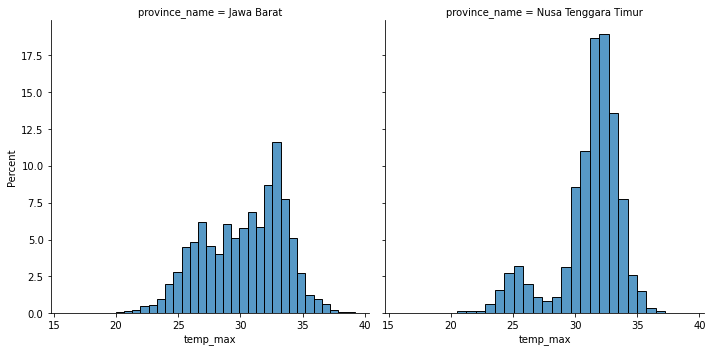

In [130]:
'''
DOC: https://seaborn.pydata.org/tutorial/axis_grids.html
'''


# plotting distributions for two of the provinces, in effort to better grasp the boxplot result

df_tmp = df_climate_data[['province_id','province_name','temp_max']]
df_tmp = df_tmp[df_tmp.province_name.isin(['Nusa Tenggara Timur', 'Jawa Barat'])]

g = sns.FacetGrid(df_tmp,col='province_name',height=5)
g.map(sns.histplot, 'temp_max', bins=30,stat='percent')

# sns.histplot(data=df_tmp,x='temp_max',bins=30,hue=df_tmp.province_name,stat='percent')

<!-- ...commentary on the above visualization 
 - The above distribution is plotted by percentage (rather than counts) in order to offset/normalize the count difference between the two provinces.
 - This visualization indicates why there are so many outliers for Nusa Tenggara Timur (from a statistical perspective). There is a sharp peak in the distribution for Nusa and wide peak for Jawa, but Nusa also seems to maintain the same overall range as Jawa (i.e. roughly between 20 C and 40C)
 - In summary, both West Java and East Nusa Tenggara have the largest standard deviations in the dataset, but exhibit such in different ways. It's not immediately clear why but such variation might be related to East Nusa Tenggara *appearing* to have more exposed coastline per square mile than West Java (provide images)
 - This supposition may be countered by Maluku Utara (North Maluku) having the lowest standard deviation but a significant amount of coastline (provide image). -->

These distributions are plotted by percentage (rather than count) in order to offset/normalize the count difference between the two provinces.

The distributions indicate (from a statistical perspective) why there are so many outliers for Nusa Tenggara Timur (East Nusa Tenggara in English). There is a sharp peak in the distribution for Nusa and wide peak for Jawa, but Nusa also seems to maintain the same overall range as Jawa (i.e. roughly between 20 C and 40 C).

In summary, both West Java and East Nusa Tenggara have the largest standard deviations in the dataset, but exhibit such in different ways. It's not immediately clear why but such variation might be related to East Nusa Tenggara *appearing* to have more exposed coastline per square mile than West Java:

__East Nusa Tenggara__

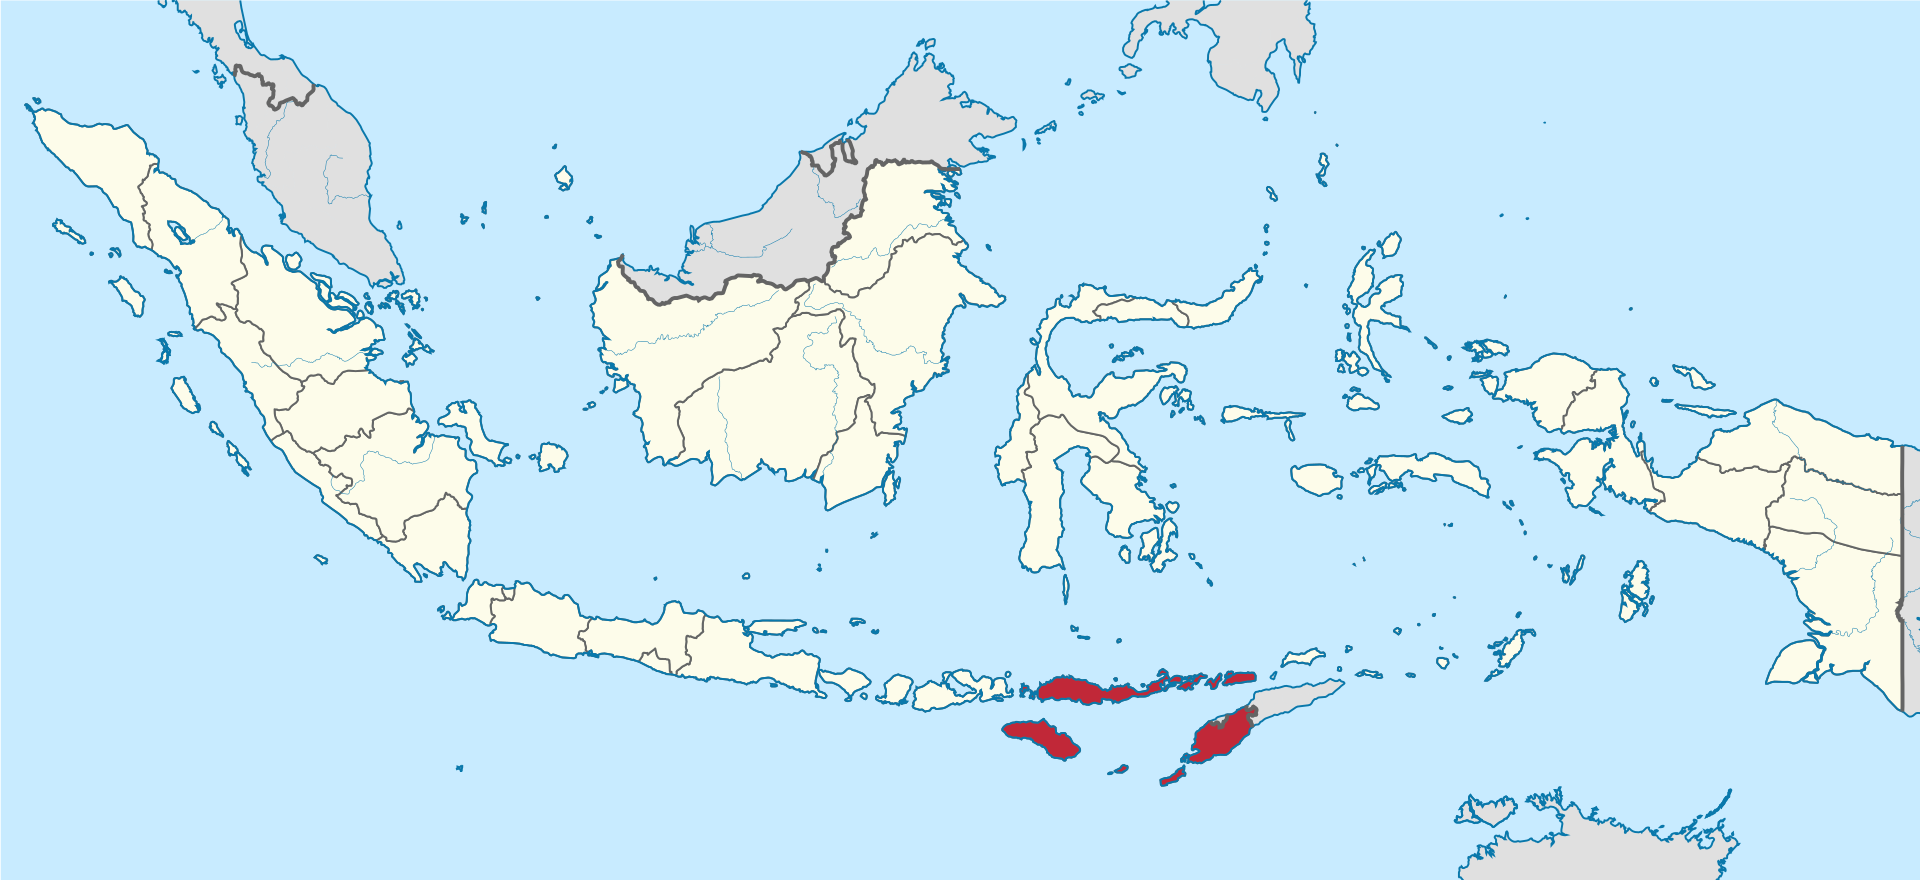

__West Java__

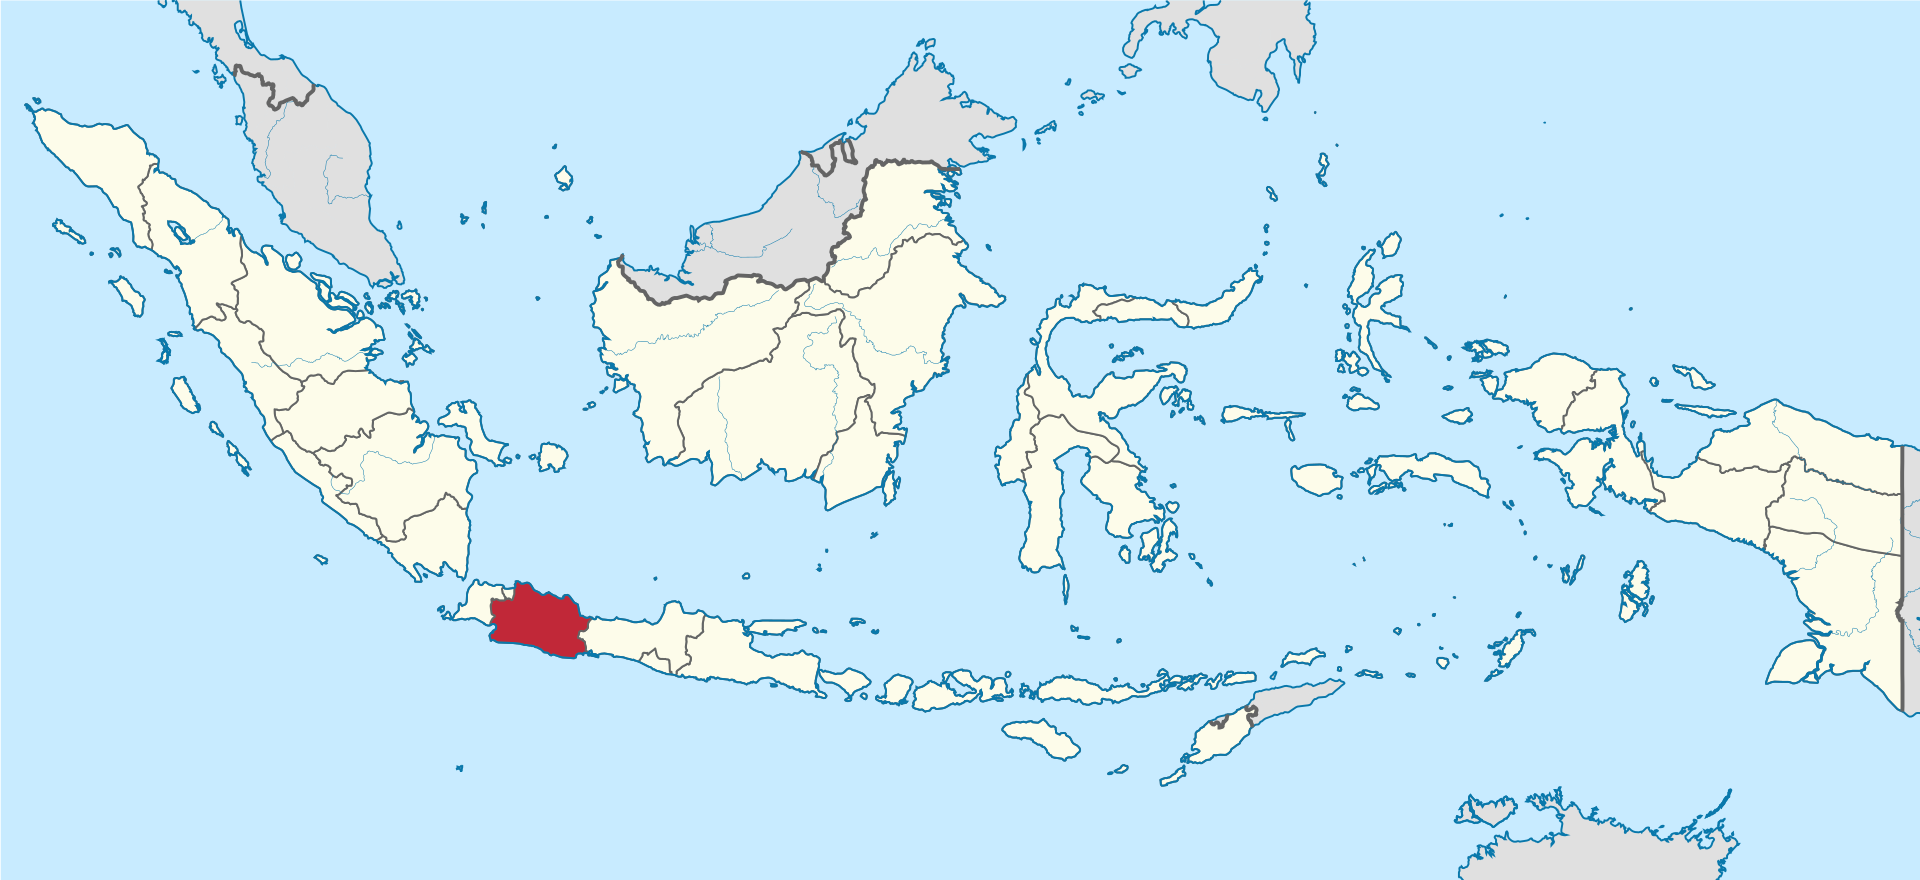

Our supposition of coastline per square mile of area correlating to the spread of the distribution **may be countered** by the fact that North Maluku, i.e. the province with the lowest spread of daily maximum temperature, seems to have a fair amount of coastline:

__North Maluku__

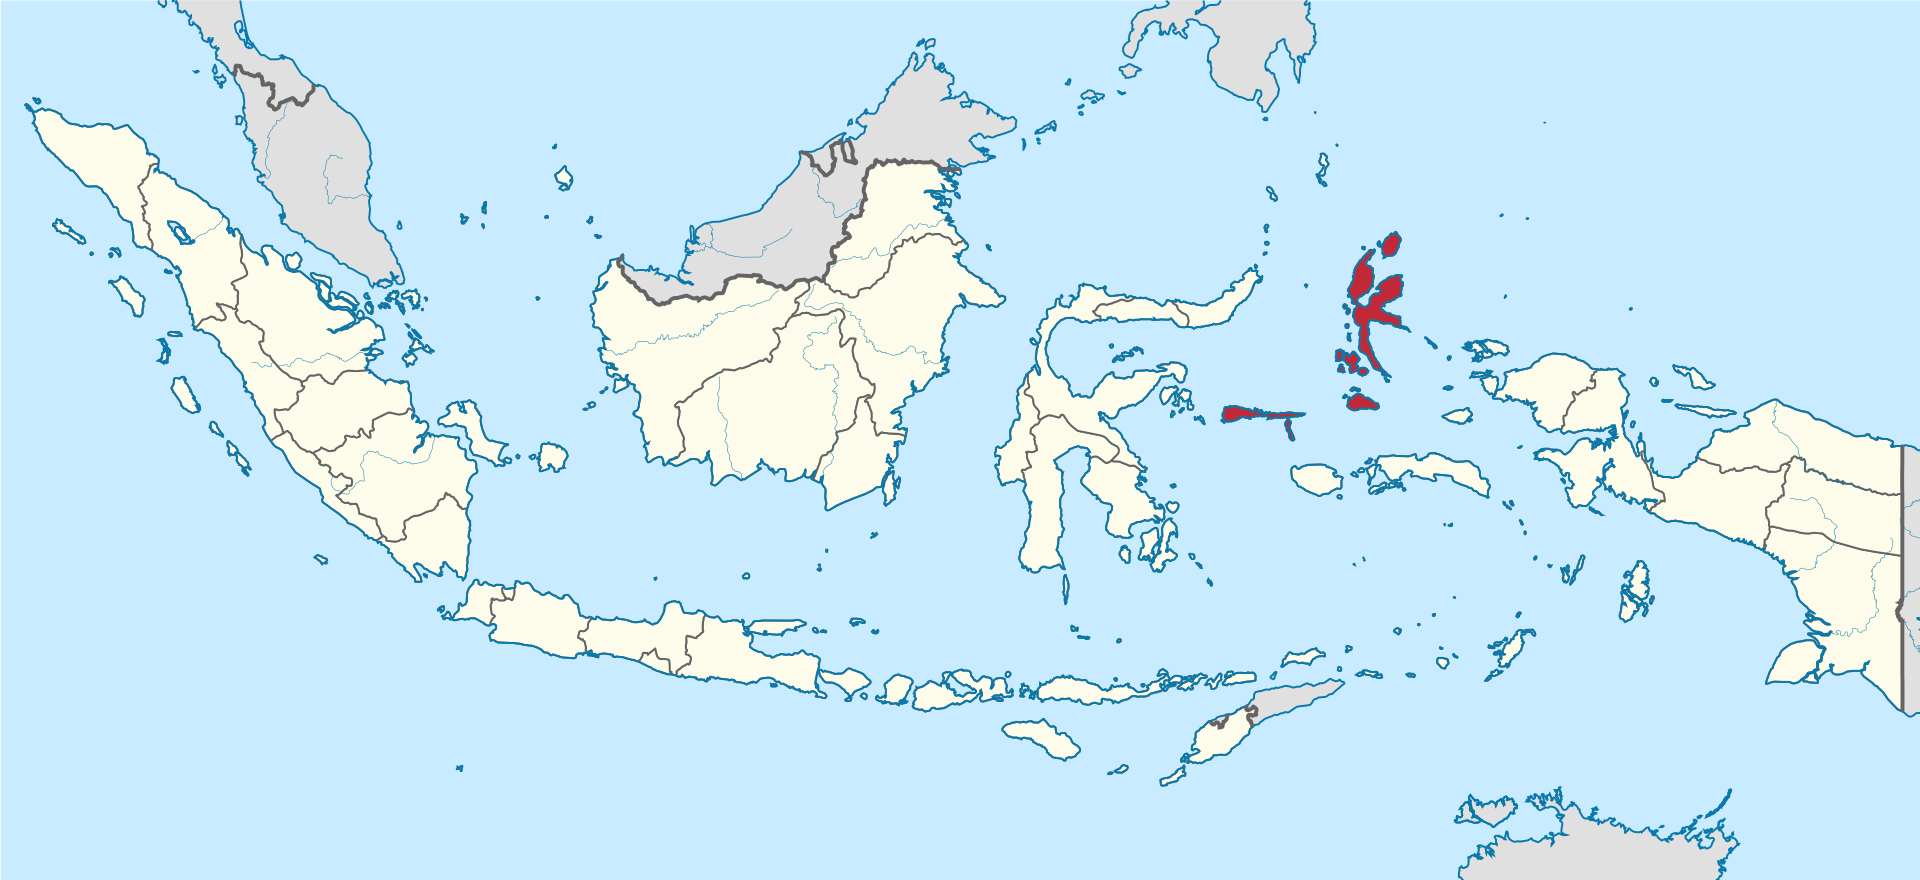

# Conclusion

*WIP*